# Interpolation and deblending examples

#### Author: Francesco Brandolin


In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import time
from itertools import cycle

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from signal_sep_pinns.Arch_Adaptive import Network
from signal_sep_pinns.ArchPE import NetworkPE
from signal_sep_pinns.train_functions import train_double_pinnslope, train_pinnslope
from signal_sep_pinns.utils import *

# set device to use CPU/GPU:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('What device are we using:', device)
dtype = torch.cuda.FloatTensor

# set seed:
set_seed(42)
g = torch.Generator()
g.manual_seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
What device are we using: cuda:0


In [4]:
deblending = {'dir':'../data/deblending/gom_blend.npy',
            'ox': 0, 'dx': 26.7, 'nx': 180, 
            'ot': 450, 'dt': 0.004, 'nt': 800+450,
            'nsub':1,
            'epochs':2000,
            'lamda':1000,
            'slope_constraint':-1,
            'n_outputs':2
            }

interp_synth_data = {'dir':'../data/interpolation/synth/seam_shot_15Hz.npy',
            'ox': 0, 'dx':10, 'nx':300, 
            'ot':850, 'dt':0.004, 'nt':1750,
            'nsub':3,
            'epochs':2000,
            'lamda':1000,
            'slope_constraint':-1,
            'n_outputs':2
            }
interp_field_data = {'dir':'../data/interpolation/field/gom_dips.npy',
            'ox': 0, 'dx': 26.7, 'nx': 180, 
            'ot': 560, 'dt': 0.004, 'nt': 340+560,
            'nsub':2,
            'epochs':2000,
            'lamda':1000,
            'slope_constraint':-1,
            'n_outputs':2
            }

### Select the experiment to run
If you want to test the old PINNslope framework (single output) on the same dataset select:
- old_PINNslope = True 
- 'n_outputs':1 (in the above data params dictionaries)

In [5]:
# Select the dataset:
par = interp_field_data

# Want to test the "double" or "single" output PINNslope frameworks ?
old_PINNslope = False

#### Prepare and display the data

Data shape: (180, 340)
Restriction Op. shape: (30600, 61200)
Subsampled data shape: (340, 90)
data_mask shape: (340, 180)


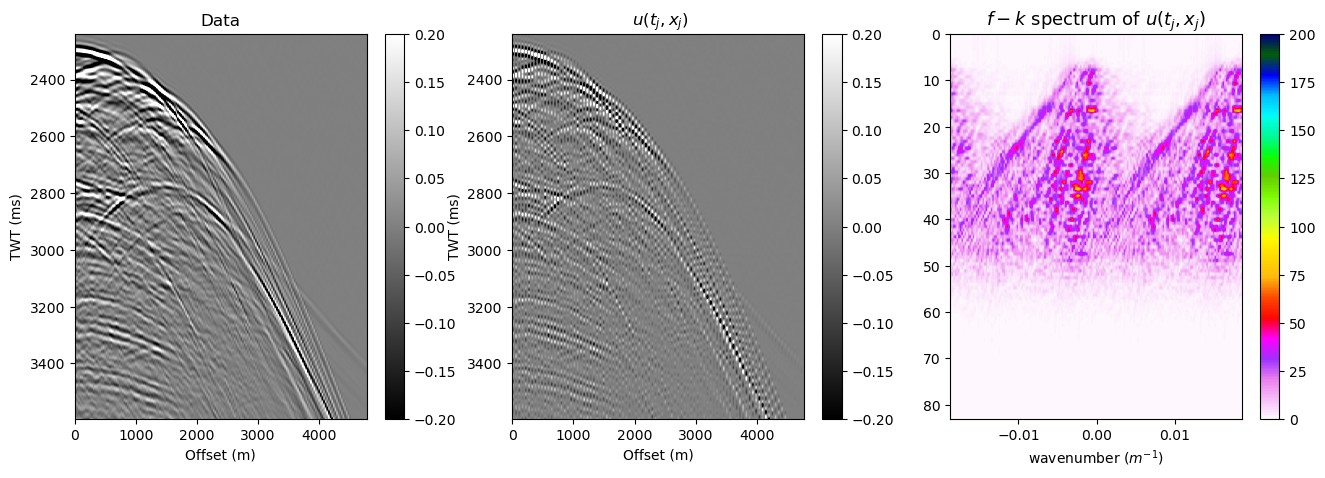

In [7]:
# Creates a directory to save the results:
value='interp_or_deb'
saveres = '../data/results/{}'.format(value)
saving_results_dir(saveres)

# Load the data:
data = np.load(par['dir']).T
print('Data shape:',data.shape)

# Data dimensions:
ox, dx,  nx = par['ox'], par['dx'], par['nx']
ot, dt, nt = par['ot'], par['dt'], par['nt']
dim_x = int(nx-ox); dim_t = int(nt-ot) 
x = (np.arange(dim_x)+ ox)* dx
x = np.reshape(x, (dim_x, 1) )
t = ((np.arange(dim_t)+ ot) * dt)*1e3
t = np.reshape(t, (dim_t, 1) )

# Subsample factor:
nsub = par['nsub'] # (if set to 1 no subsampling)

# Create restriction operator:
traces_index = np.arange( dim_x )
traces_index_sub = traces_index[::nsub]  
Rop = pylops.Restriction([dim_x, dim_t], 
                         iava=traces_index_sub, 
                         axis=0, 
                         dtype="float64" 
                         )
print('Restriction Op. shape:',Rop.shape)

# Apply restriction Operator to the data:
data_obs, datamask = ROp(Rop, data, traces_index_sub, dim_t)

# Display CMP and Trace selected:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1, 1]})
vmin=-.2; vmax=.2
CMP = axs[0].imshow(data.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('Data')
fig.colorbar(CMP, ax=axs[0])
axs[0].axis('tight')

CMP1 = axs[1].imshow(datamask.data, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (ms)')
axs[1].set_title(r' $u(t_{j}, x_{j})$')
fig.colorbar(CMP1, ax=axs[1])
axs[1].axis('tight')

f, kx = np.fft.fftfreq(dim_t, dt), np.fft.fftfreq(dim_x, dx)
FFTsub = np.fft.fft2(datamask[:,:])

limit_plot=FFTsub.shape[0]//3
FFTsubdata=axs[2].imshow(np.fft.fftshift(np.abs(FFTsub[:limit_plot]), axes=1), cmap='gist_ncar_r', vmin=0, vmax=200, extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1], f[limit_plot], f[0]) )
axs[2].set_xlabel('wavenumber ($m^{-1}$)',)
axs[2].set_title('$f-k$ spectrum of'+r' $u(t_{j}, x_{j})$', fontsize=13)
fig.colorbar(FFTsubdata, ax=axs[2])
axs[2].axis('tight')
# plt.savefig(saveres + "/intro.png", format='png', bbox_inches='tight')
plt.show()

### Creating and processing the computational grid

- In this cell the computational grid is created. Then the grid points associated with the position of training traces (right fig. above) are extracted, these are the points passed in the data term of the loss.
  
- Also, the training traces are reshaped and stacked one below the other to be easily pass to the data-term term during the network training.

In [8]:
# Creating computational grid:
grx, grt, grX, grT, full_grid = grid(ox, dx, nx, ot, dt, nt, normalization=True)
print('full_grid size', full_grid.shape )

# Creating training traces grid-points from full grid:
traces_training_grid = grid_subsampling(grX, grT, Rop, traces_index_sub.shape[0])
print('traces_training_grid size:', traces_training_grid.shape)

# Reshaping subsampled data to trainig traces:
ground_truth_traces = training_traces(data_obs)
print('ground_truth_traces size:', ground_truth_traces.shape)

full_grid size (61200, 2)
traces_training_grid size: (30600, 2)
ground_truth_traces size: (30600, 1)


### Hyperparameteres settings, Network initialization and Dataloader

- Sets the hyperparameters for training.

- Creates two TensorDatasets one with the full grid and one with the training traces grid points and the training traces. 

In [ ]:
# Choose the learning rate:
lr = 1e-3
# Choose number of epochs:
epochs = par['epochs']

# Grid batches:
batch_grid_slope = 1000
n_grid_slope_batches = int((full_grid.shape[0])/batch_grid_slope)
print(' - Number of Grid/Slope batches:', n_grid_slope_batches)

# Training traces batches:
n_train_traces_batches = 2
batch_traces_size = int((ground_truth_traces.shape[0])/n_train_traces_batches)
print(' - Traces batch size:',batch_traces_size)

# Data term Loss function:
Loss1 = nn.L1Loss(reduction='mean')

# Define the weight for the data term:
lamdas = [par['lamda']]

# Wavefield network:
lay = 'linear' 
act = 'Tanh'  
PosEnc=[8,32,2]
model = NetworkPE((PosEnc[0]*2+PosEnc[1]*2), 
                  par['n_outputs'], 
                  [512,512,512,512], 
                  act=act, 
                  lay=lay, 
                  PosEnc=PosEnc, 
                  device=device
                  ).to(device)

# Choose the optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Slope network:
modelSlope = Network(2, 
                     par['n_outputs'], 
                     [8,8,8,8], 
                     act=act, 
                     lay=lay
                     ).to(device)

# Optimizer:
optimizer_slope = torch.optim.Adam(modelSlope.parameters(), lr=lr)

# Preparing DataLoaders for grid-points (t_i, x_i):
grid_slope = torch.from_numpy(full_grid).type(dtype).to(device)
print(' - Torch Tens grid-slope points size:',grid_slope.shape)

fullgrid_loader = DataLoader(TensorDataset(grid_slope), 
                                batch_size=batch_grid_slope, 
                                shuffle=True, 
                                drop_last=True, 
                                generator=g
                                )

# Preparing DataLoaders for grid-points (t_j, x_j) and available data u(t_j, x_j):
tracesGrid_tracesGT = np.concatenate(( traces_training_grid, ground_truth_traces ), axis=1)
print('Concat of grid and ground truth traces points size:', tracesGrid_tracesGT.shape)
tracesGrid_tracesGT = torch.from_numpy(tracesGrid_tracesGT).type(dtype).to(device)
print(' - Torch Tens grid-GT points size:',tracesGrid_tracesGT.shape)

tracesGrid_tracesGT_loader = DataLoader( TensorDataset(tracesGrid_tracesGT), 
                                        batch_size=batch_traces_size, 
                                        shuffle=True, 
                                        drop_last=True, 
                                        generator=g
                                        )

 - Number of Grid/Slope batches: 61
 - Traces batch size: 15300
 - Torch Tens grid-slope points size: torch.Size([61200, 2])
Concat of grid and ground truth traces points size: (30600, 3)
 - Torch Tens grid-GT points size: torch.Size([30600, 3])


### Training function

In [ ]:
# Loading the Double output PINNslope training function:
if old_PINNslope == False: 
    training = train_double_pinnslope

# Loading the Single output PINNslope training function:
else : 
    training = train_pinnslope

# Initialize arrays to store losses:
training_loss, loss_data_values, loss_phy_values = np.zeros(epochs), np.zeros(epochs), np.zeros(epochs)

# Initialize rec time:
start = time.time()


# Run the network:
for epoch in range( epochs ):
    
    if epoch % 100==0:
        print('epoch:', epoch)

    training_loss[epoch], loss_data_values[epoch], loss_phy_values[epoch] = \
        training([model, modelSlope], 
                    [optimizer, optimizer_slope], 
                    Loss1, 
                    lamdas,  
                    fullgrid_loader, 
                    tracesGrid_tracesGT_loader, 
                    c2=par['slope_constraint']
                    )

end = time.time()
print('Total Runtime is: %f [minutes] ' %((end-start)/60))

In [ ]:
# Model evaluation:

if old_PINNslope == False:  
    # Evaluating the Double PINNslope framework
    model.eval()
    
    u_out = model(torch.from_numpy(full_grid).type(dtype).to(device).requires_grad_(True))
                
    u_npy = u_out.detach().cpu().numpy()
    u1 = ( np.reshape(u_npy[:,0], (dim_x, dim_t)) ).T
    u2 = ( np.reshape(u_npy[:,1], (dim_x, dim_t)) ).T


    modelSlope.eval()
    
    # Constrain output:
    sigmoid = torch.nn.Sigmoid()
    c2 = torch.tensor(par['slope_constraint']) # negative slope prediction

    sigma_out = modelSlope(torch.from_numpy(full_grid).type(dtype).to(device).requires_grad_(True))

    sigma1 = ( sigmoid(sigma_out[:,0]) ).detach().cpu().numpy()
    sigma2 = ( sigmoid(sigma_out[:,1]) * c2 ).detach().cpu().numpy()
    sigma1 = ( np.reshape(sigma1, (dim_x,dim_t)) ).T
    sigma2 = ( np.reshape(sigma2, (dim_x,dim_t)) ).T

else: 
    # Evaluating the Single output PINNslope framework
    model.eval()

    u_out = model( torch.from_numpy(full_grid).type(dtype).requires_grad_(True) )
    u_npy = ( np.reshape(u_out.detach().cpu().numpy(), (dim_x, dim_t)) ).T

    modelSlope.eval()
    sigma_out = modelSlope( torch.from_numpy(full_grid).type(dtype).to(device).requires_grad_(True) )
    sigma_npy = ( np.reshape(sigma_out.detach().cpu().numpy(), (dim_x, dim_t)) ).T

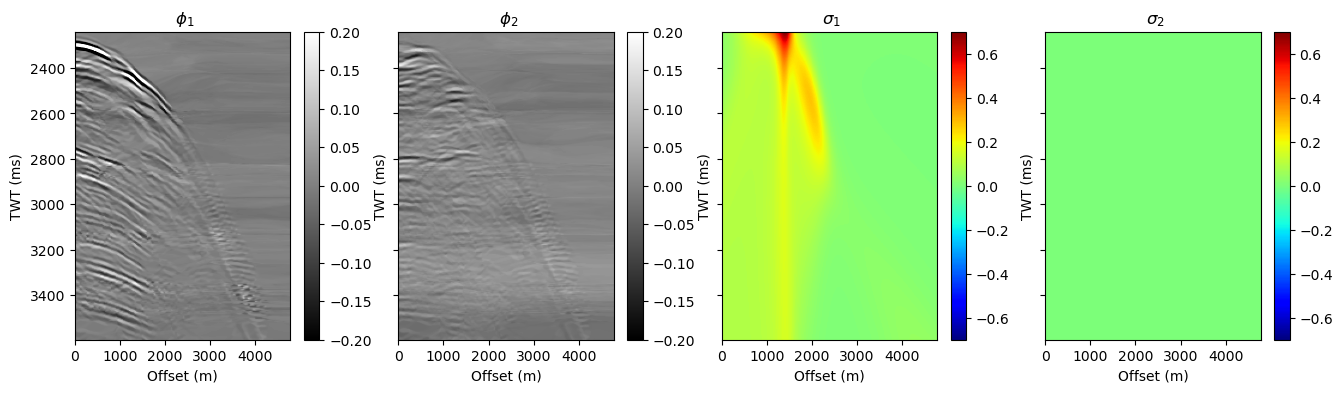

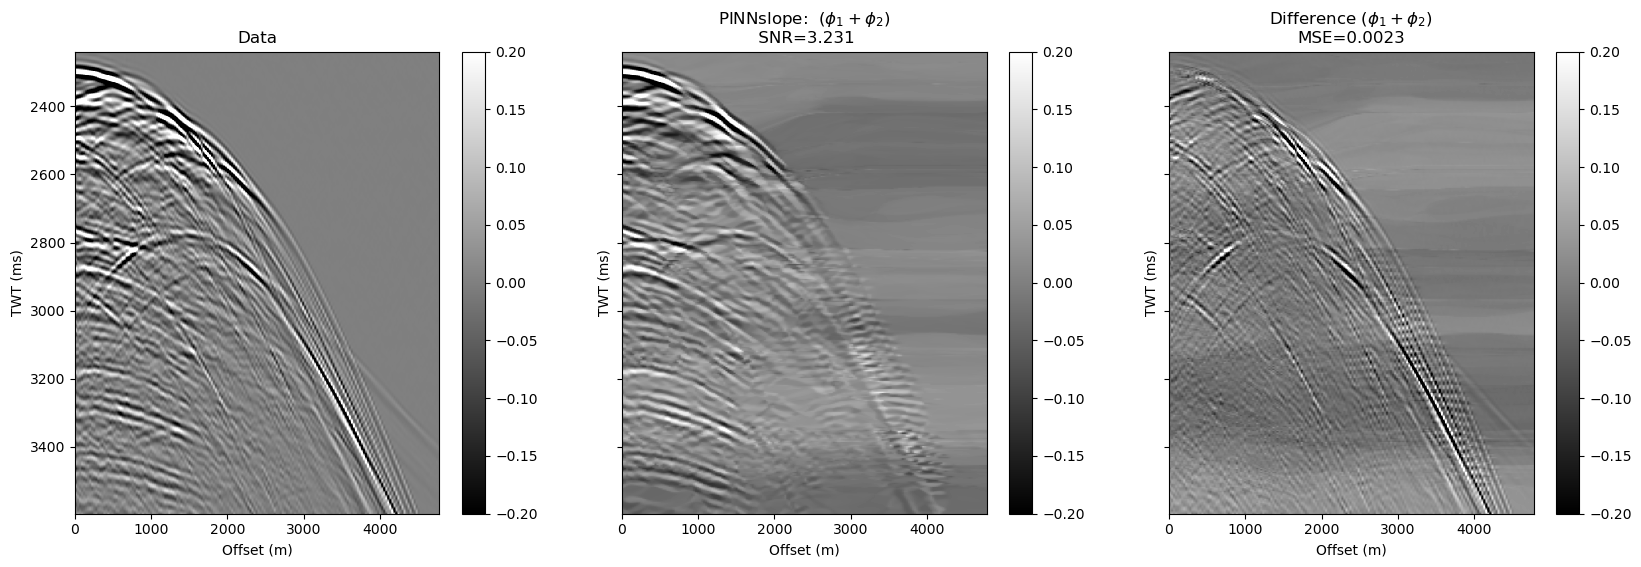

In [11]:
# Results:

if old_PINNslope == False:  

    fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
    vmin=-.2; vmax=.2
    CMP=axs[0].imshow(u1, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[0].set_xlabel('Offset (m)')
    axs[0].set_ylabel('TWT (ms)')
    axs[0].set_title(r' $\phi_{1}$')
    fig.colorbar(CMP, ax=axs[0])
    axs[0].axis('tight')

    OUT=axs[1].imshow(u2, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[1].set_xlabel('Offset (m)')
    axs[1].set_ylabel('TWT (ms)')
    axs[1].set_title(r' $\phi_{2}$' )
    fig.colorbar(OUT, ax=axs[1])
    axs[1].axis('tight')


    vmax=np.max(sigma1); vmin=-vmax;

    CMP=axs[2].imshow(sigma1, cmap='jet', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[2].set_xlabel('Offset (m)')
    axs[2].set_ylabel('TWT (ms)')
    axs[2].set_title(r' $ \sigma_{1}$')
    fig.colorbar(CMP, ax=axs[2])
    axs[2].axis('tight')

    OUT=axs[3].imshow(sigma2, cmap='jet', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[3].set_xlabel('Offset (m)')
    axs[3].set_ylabel('TWT (ms)')
    axs[3].set_title(r' $ \sigma_{2}$' )
    fig.colorbar(OUT, ax=axs[3])
    axs[3].axis('tight')
    # plt.savefig(saveres + "/slope.png", format='png', bbox_inches='tight')
    plt.show()


    # Results:
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1]})
    vmin=-0.2; vmax=0.2
    CMP=axs[0].imshow(data.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[0].set_xlabel('Offset (m)')
    axs[0].set_ylabel('TWT (ms)')
    axs[0].set_title('Data')
    fig.colorbar(CMP, ax=axs[0])
    axs[0].axis('tight')

    OUT=axs[1].imshow(u1+u2, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[1].set_xlabel('Offset (m)')
    axs[1].set_ylabel('TWT (ms)')
    axs[1].set_title('PINNslope: ' + r' $(\phi_{1}+\phi_{2})$'+ '\n SNR={}'.format( round(snr(data.T,u1+u2),3) ) )
    fig.colorbar(OUT, ax=axs[1])
    axs[1].axis('tight')

    DIFF=axs[2].imshow(( data.T-(u1+u2) ), cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[2].set_xlabel('Offset (m)')
    axs[2].set_ylabel('TWT (ms)')
    axs[2].set_title('Difference' + r' $(\phi_{1}+\phi_{2})$'+'\nMSE={}'.format( round((mse(data.T, u1+u2)),4) ) )
    fig.colorbar(DIFF, ax=axs[2])
    axs[2].axis('tight')
    # plt.savefig(saveres + "/wav_diff.png", format='png', bbox_inches='tight')
    plt.show()

else:

    # Results:
    fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
    vmin=-0.2; vmax=0.2
    CMP=axs[0].imshow(data.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[0].set_xlabel('Offset (m)')
    axs[0].set_ylabel('TWT (ms)')
    axs[0].set_title('Data')
    fig.colorbar(CMP, ax=axs[0])
    axs[0].axis('tight')

    OUT=axs[1].imshow(u_npy, cmap='gray',  vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[1].set_xlabel('Offset (m)')
    axs[1].set_ylabel('TWT (ms)')
    axs[1].set_title('PINNslope: ' + r'$\phi_{\theta}(t,x)$ ' )
    fig.colorbar(OUT, ax=axs[1])
    axs[1].axis('tight')

    DIFF=axs[2].imshow((data.T-u_npy), cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[2].set_xlabel('Offset (m)')
    axs[2].set_ylabel('TWT (ms)')
    axs[2].set_title('Difference' )
    fig.colorbar(DIFF, ax=axs[2])
    axs[2].axis('tight')

    SLOPE=axs[3].imshow(sigma_npy, cmap='jet', extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    axs[3].set_xlabel('Offset (m)')
    axs[3].set_ylabel('TWT (ms)')
    axs[3].set_title('PINNslope: ' + r'$ \sigma_{\theta_{2}}(t,x)$' )
    fig.colorbar(SLOPE, ax=axs[3])
    axs[3].axis('tight')

    # plt.savefig(saveres + "/result.png", format='png', bbox_inches='tight')
    plt.show()

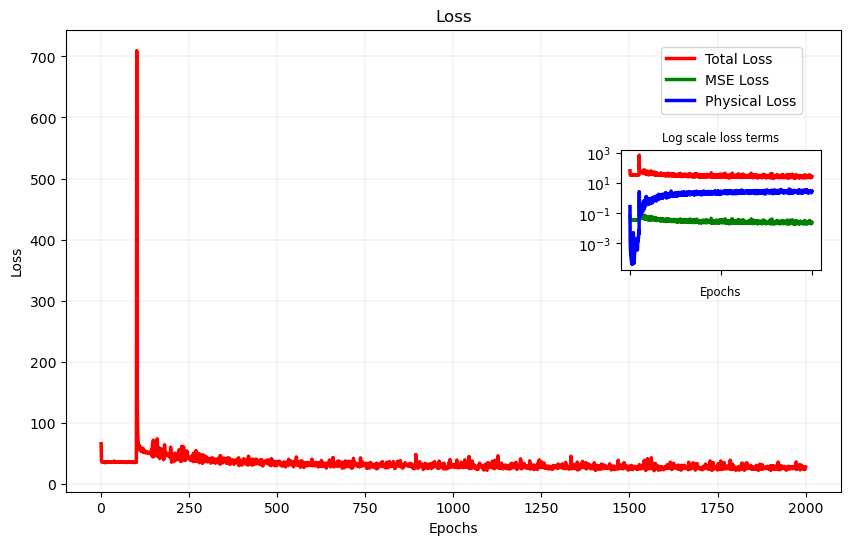

In [ ]:
# Plotting the Loss:  
plot_loss(epochs, loss_phy_values, loss_data_values, training_loss )
# plt.savefig(saveres + "/loss.png", format='png', bbox_inches='tight')
plt.show()

In [ ]:
# Store the hyperparameters used in the current experiment in .txt file
store_param = {'runtime':(end-start)/60, 
               'epochs':epochs, 
               'lr':lr, 
               'lambda':par['lamda'],
               'DataNetwork':model,
               'SlopeNetwork':modelSlope}
with open(saveres + '/param_summary.txt', 'w') as f:
    f.write("%s = %s\n" %("store_param", store_param))

# # Uncomment to save output files:

# torch.save(model.state_dict(), saveres + '/SEAMshot.pt')
# torch.save(modelSlope.state_dict(), saveres + '/slopeSEAMshot.pt')
# np.save(saveres + '/u1.npy', u1)
# np.save(saveres + '/u2.npy', u2)
# np.save(saveres + '/slope1.npy', sigma1)
# np.save(saveres + '/slope2.npy', sigma2)
# np.save(saveres + '/lossphy.npy', loss_phy_values)
# np.save(saveres + '/lossdata.npy', loss_data_values)
# np.save(saveres + '/losstot.npy', loss_values)